# Prepare matplotlib

In [1]:
import json
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator, NullFormatter

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)

# Load data

In [2]:
# Functions for loading BLiMP data


def load_blimp_data(path: Path) -> dict:
    with path.open() as f:
        data = json.load(f)
    if "blimp" in data:
        data = data["blimp"]
    return data


def get_uids(data: dict):
    return np.array(list(data["by_uid"].values()))

In [9]:
# Load all BLiMP data

SCALE = "tiny"

uid_data = []
steps = list(range(0, 20_001, 1_000))
for i in steps:
    baseline_data = load_blimp_data(Path(f"blimp_results_{SCALE}/step_{i}.json"))
    base_uids = get_uids(baseline_data)

    relora_data = load_blimp_data(Path(f"relora-{SCALE}-eval/step_{i}.json"))
    relora_uids = get_uids(relora_data)

    step_data = np.column_stack([base_uids, relora_uids])
    uid_data.append(step_data)

uid_data = np.column_stack(uid_data)

In [10]:
base = np.mean(uid_data[:, -2])
relora = np.mean(uid_data[:, -1])

print(np.mean(uid_data[:, -2] - uid_data[:, -1]))  # small = 0.07, tiny = 0.026

(base - relora) / base * 100

# tiny: 4.11%

# small: 10.07%


small = load_blimp_data(Path("relora-small-eval/step_20000.json"))
small_uids = get_uids(small)
tiny = load_blimp_data(Path("relora-tiny-eval/step_20000.json"))
tiny_uids = get_uids(tiny)
print("RELORA", np.mean((small_uids - tiny_uids) / tiny_uids))

small = load_blimp_data(Path("blimp_results_small/step_20000.json"))
small_uids = get_uids(small)
tiny = load_blimp_data(Path("blimp_results_tiny/step_20000.json"))
tiny_uids = get_uids(tiny)
print("BASE", np.mean((small_uids - tiny_uids) / tiny_uids))

0.0267462677030421
RELORA 0.06037209127099493
BASE 0.10876636338754972


/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_89139/431142821.py:95: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


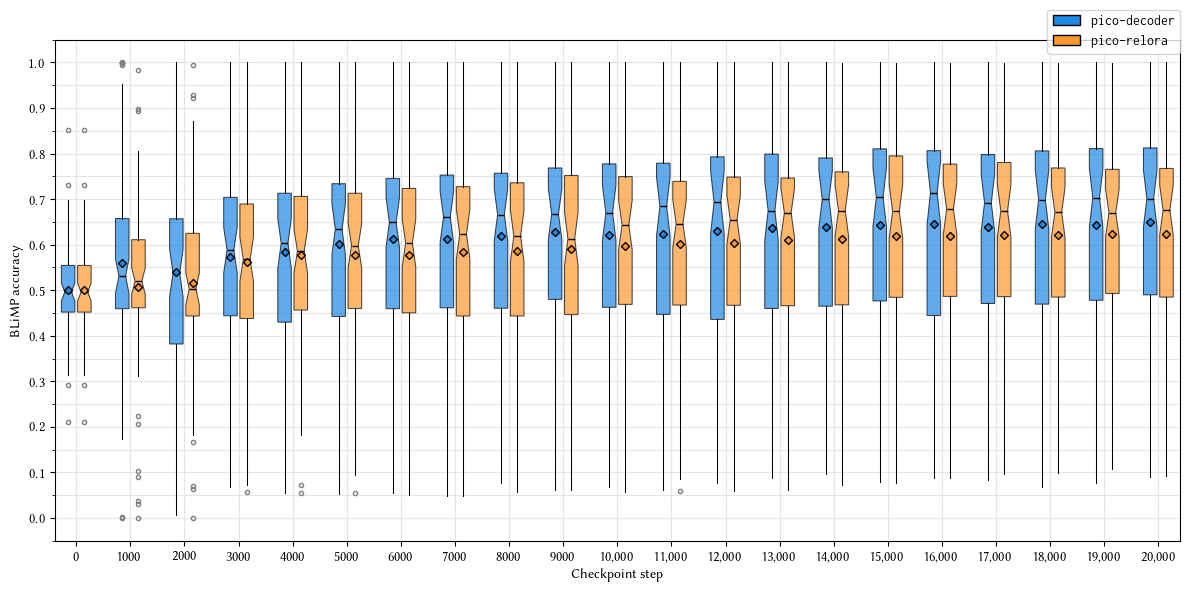

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

labels = [r"\texttt{pico-decoder}", r"\texttt{pico-relora}"]

positions = []

steps = np.arange(0, 21, 1) * 2

group_width = 0.9  # Total width for each group of boxes
box_width = 0.5
box_offset = 0.05
real_offset = (box_width / 2) + box_offset
positions = []

for i in steps:
    positions.extend([i - real_offset, i + real_offset])

LINE_WEIGHT = 0.75

boxplot = ax.boxplot(
    uid_data,
    patch_artist=True,
    sym=".",
    notch=True,
    showcaps=False,
    positions=positions,
    widths=box_width,
    medianprops={"color": "black", "linewidth": LINE_WEIGHT + 0.25},
    boxprops={"linewidth": LINE_WEIGHT},
    whiskerprops={"linewidth": LINE_WEIGHT},
    flierprops={
        # "markerfacecolor": "#807F7F",
        "markeredgecolor": "#807F7F",
        "markersize": 6,
    },
)

# Set colors for boxes
colors = ["#1E88E5", "#FF992F"]
for idx, patch in enumerate(boxplot["boxes"]):
    patch.set_facecolor(colors[idx % 2])
    patch.set_alpha(0.7)

for idx, (pos, ts) in enumerate(zip(positions, uid_data.T)):
    ax.plot(
        pos,
        np.mean(ts),
        marker="D",
        markersize=4,
        markerfacecolor=colors[idx % 2],
        markeredgecolor="black",
        markeredgewidth=1,
        zorder=5,
        linestyle="None",
    )

ax.set_ylabel("BLiMP accuracy")


ax.set_xticks(steps, labels=[f"{(i * 1000):,}" if i >= 10 else str(i * 1000) for i in range(0, 21)])

ax.set_xlabel(r"Checkpoint step")

ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
ax.yaxis.set_minor_formatter(NullFormatter())


ax.grid(which="both", axis="both", color="#E5E5E5")

legend_elements = [
    Patch(facecolor=color, edgecolor="black", label=label) for color, label in zip(colors, labels)
]
# legend_elements.append(
#     Line2D(
#         [0],
#         [0],
#         marker="D",
#         markersize=5,
#         markerfacecolor="white",
#         markeredgecolor="black",
#         markeredgewidth=1.5,
#         label="mean",
#         linestyle="",
#     )
# )


# Add the legend
ax.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1, 1.06), borderaxespad=0)

fig.tight_layout()
fig.savefig(f"../graphs/{SCALE}_blimp_box.pdf")
fig.show()

# Load data for phenomenon plots

In [12]:
from collections import defaultdict

blimp_uid_to_phenomenon = {
    # Anaphor Agreement
    "anaphor_gender_agreement": "Anaphor Agreement",
    "anaphor_number_agreement": "Anaphor Agreement",
    "animate_subject_passive": "Anaphor Agreement",
    "animate_subject_trans": "Anaphor Agreement",
    # Argument Structure
    "causative": "Argument Structure",
    "drop_argument": "Argument Structure",
    "inchoative": "Argument Structure",
    "intransitive": "Argument Structure",
    "passive_1": "Argument Structure",
    "passive_2": "Argument Structure",
    "transitive": "Argument Structure",
    # Binding
    "principle_A_c_command": "Binding",
    "principle_A_case_1": "Binding",
    "principle_A_case_2": "Binding",
    "principle_A_domain_1": "Binding",
    "principle_A_domain_2": "Binding",
    "principle_A_domain_3": "Binding",
    "principle_A_reconstruction": "Binding",
    # Control/Raising
    "existential_there_object_raising": "Control/Raising",
    "existential_there_subject_raising": "Control/Raising",
    "tough_vs_raising_1": "Control/Raising",
    "tough_vs_raising_2": "Control/Raising",
    "expletive_it_object_raising": "Control/Raising",
    # Determiner-Noun Agreement
    "determiner_noun_agreement_1": "Determiner-Noun Agreement",
    "determiner_noun_agreement_2": "Determiner-Noun Agreement",
    "determiner_noun_agreement_irregular_1": "Determiner-Noun Agreement",
    "determiner_noun_agreement_irregular_2": "Determiner-Noun Agreement",
    "determiner_noun_agreement_with_adj_1": "Determiner-Noun Agreement",
    "determiner_noun_agreement_with_adjective_1": "Determiner-Noun Agreement",  # appears like this too
    "determiner_noun_agreement_with_adj_2": "Determiner-Noun Agreement",
    "determiner_noun_agreement_with_adj_irregular_1": "Determiner-Noun Agreement",
    "determiner_noun_agreement_with_adj_irregular_2": "Determiner-Noun Agreement",
    # Ellipsis
    "ellipsis_n_bar_1": "Ellipsis",
    "ellipsis_n_bar_2": "Ellipsis",
    # Filler-Gap
    "wh_questions_object_gap": "Filler-Gap",
    "wh_questions_subject_gap": "Filler-Gap",
    "wh_questions_subject_gap_long_distance": "Filler-Gap",
    "wh_vs_that_no_gap": "Filler-Gap",
    "wh_vs_that_no_gap_long_distance": "Filler-Gap",
    "wh_vs_that_with_gap": "Filler-Gap",
    "wh_vs_that_with_gap_long_distance": "Filler-Gap",
    # Irregular Forms
    "irregular_past_participle_adjectives": "Irregular Forms",
    "irregular_past_participle_verbs": "Irregular Forms",
    # Island Effects
    "adjunct_island": "Island Effects",
    "complex_NP_island": "Island Effects",
    "coordinate_structure_constraint_complex_left_branch": "Island Effects",
    "coordinate_structure_constraint_object_extraction": "Island Effects",
    "left_branch_island_echo_question": "Island Effects",
    "left_branch_island_simple_question": "Island Effects",
    "sentential_subject_island": "Island Effects",
    "wh_island": "Island Effects",
    # NPI Licensing
    "matrix_question_npi_licensor_present": "NPI Licensing",
    "npi_present_1": "NPI Licensing",
    "npi_present_2": "NPI Licensing",
    "only_npi_licensor_present": "NPI Licensing",
    "only_npi_scope": "NPI Licensing",
    "sentential_negation_npi_licensor_present": "NPI Licensing",
    "sentential_negation_npi_scope": "NPI Licensing",
    # Quantifiers
    "existential_there_quantifiers_1": "Quantifiers",
    "existential_there_quantifiers_2": "Quantifiers",
    "superlative_quantifiers_1": "Quantifiers",
    "superlative_quantifiers_2": "Quantifiers",
    # Subject-Verb Agreement
    "distractor_agreement_relational_noun": "Subject-Verb Agreement",
    "distractor_agreement_relative_clause": "Subject-Verb Agreement",
    "irregular_plural_subject_verb_agreement_1": "Subject-Verb Agreement",
    "irregular_plural_subject_verb_agreement_2": "Subject-Verb Agreement",
    "regular_plural_subject_verb_agreement_1": "Subject-Verb Agreement",
    "regular_plural_subject_verb_agreement_2": "Subject-Verb Agreement",
}


phenomena = sorted(list(set(blimp_uid_to_phenomenon.values())))


def group_by_phenomenon(data: dict):
    res = defaultdict(list)
    for uid, val in data["by_uid"].items():
        res[blimp_uid_to_phenomenon[uid]].append(val)
    return res

In [13]:
# Load all BLiMP data -- by phenomenon
phen_data = []
STEP = 20_000

baseline_data = load_blimp_data(Path(f"blimp_results_{SCALE}/step_{STEP}.json"))
base_phenoms = group_by_phenomenon(baseline_data)

relora_data = load_blimp_data(Path(f"relora-{SCALE}-eval/step_{STEP}.json"))
relora_phenoms = group_by_phenomenon(relora_data)

for p in phenomena:
    phen_data.append(base_phenoms[p])
    phen_data.append(relora_phenoms[p])

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_89139/1908394416.py:95: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


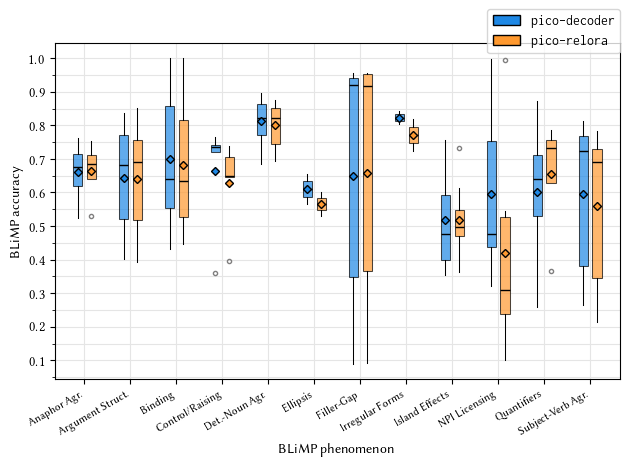

In [14]:
fig, ax = plt.subplots()

labels = [r"\texttt{pico-decoder}", r"\texttt{pico-relora}"]

positions = []

ticks = np.arange(len(phenomena))

group_width = 0.9  # Total width for each group of boxes
box_width = 0.2
box_offset = 0.05
real_offset = (box_width / 2) + box_offset
positions = []

for i in ticks:
    positions.extend([i - real_offset, i + real_offset])

LINE_WEIGHT = 0.75

boxplot = ax.boxplot(
    phen_data,
    patch_artist=True,
    sym=".",
    notch=False,
    showcaps=False,
    positions=positions,
    widths=box_width,
    medianprops={"color": "black", "linewidth": LINE_WEIGHT + 0.25},
    boxprops={"linewidth": LINE_WEIGHT},
    whiskerprops={"linewidth": LINE_WEIGHT},
    flierprops={
        # "markerfacecolor": "#807F7F",
        "markeredgecolor": "#807F7F",
        "markersize": 6,
    },
)

# Set colors for boxes
colors = ["#1E88E5", "#FF992F"]
for idx, patch in enumerate(boxplot["boxes"]):
    patch.set_facecolor(colors[idx % 2])
    patch.set_alpha(0.7)

for idx, (pos, phen) in enumerate(zip(positions, phen_data)):
    ax.plot(
        pos,
        np.mean(phen),
        marker="D",
        markersize=4,
        markerfacecolor=colors[idx % 2],
        markeredgecolor="black",
        markeredgewidth=1,
        zorder=5,
        linestyle="None",
    )

ax.set_ylabel("BLiMP accuracy")


def shorten_label(label: str):
    label = label.replace("Agreement", "Agr.")
    label = label.replace("Determiner", "Det.")
    label = label.replace("Structure", "Struct.")
    return label


ax.set_xticks(
    ticks,
    labels=[shorten_label(lab) for lab in phenomena],
    fontsize=8,
    rotation=30,
    ha="right",
    rotation_mode="default",
)

ax.set_xlabel(r"BLiMP phenomenon")

ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}"))
ax.yaxis.set_minor_formatter(NullFormatter())


ax.grid(which="both", axis="both", color="#E5E5E5")

legend_elements = [
    Patch(facecolor=color, edgecolor="black", label=label) for color, label in zip(colors, labels)
]

# Add the legend
ax.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1, 1.1), borderaxespad=0)

fig.tight_layout()
fig.savefig(f"../graphs/{SCALE}_blimp_phenom_box.pdf")
fig.show()